# Running QuEStVar on All Cancer Cell Line Pairs

- **License:** [MIT License](https://opensource.org/licenses/MIT)
- **Version:** 0.2
- **Edit Log:** 
    - 2024-01-19: Initial version of the notebook
    - 2024-02-21: Revised the notes 

**Data Information:**

The data used here comes from the previous notebook where I prepared the data for the `questvar` testing framework. The data is stored in the `data/processed/` folder and is described in the previous notebook. Especially the `data/processed/samples/` folder that contains the subset of each sample saved as a feather file will be called when each pair comparison is run. 

**Notebook Summary:**

This notebook uses the prepared data from the previous notebook to run the `questvar` testing framework and summarize the results. At the end I also do a comparison of correlation coefficient and equivalence percent (extracted with questvar) to see which one is a more robust way to measure sample similarity.

## Setup Notebook

This part is a standard for my notebooks, where I import the all used libraries, set the design of the notebook, and define the paths for data and figures. 

> **Note:** The HTML rendering of this notebook will not show the code cells by default, but the code can be visible by clicking the "code" buttons aligned on the right.

### Libraries Used

In [1]:
import os 
import sys
import glob
import feather
import warnings
from multiprocessing import Pool
from itertools import combinations

import numpy as np # Python's numerical library
import pandas as pd # Python's data manipulation library
import polars as pl # Python's data manipulation library (Rust backend)

import seaborn as sns # R-like high-level plots
import matplotlib.pyplot as plt # Python's base plotting 
import matplotlib.ticker as mtick # Format tick labels

sys.path.append('../')
from questvar import test, utils, plots
warnings.filterwarnings('ignore')
nbStartTime = utils.getTime()

### Notebook's Design

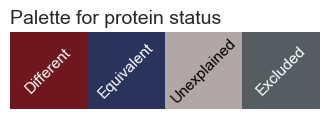

In [2]:
### Notebook Configuration
## Colors
# def_colors = ["#29335c","#7e8cc6","#565d61","#ff8020","#eeeeee","#70161e","#d06770"]

# Color dict for the protein status
status_colors = {
    "Different": "#70161e",
    "Equivalent": "#29335c",
    "Unexplained": "#b1a7a6",
    "Excluded": "#565d61"
}

## Configure some general styling
# Set seaborn style
sns.set_theme(
    style="white",
    context="paper",
    # palette=def_colors,
    font_scale=1,
    rc={
        "figure.figsize": (6, 4),
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
    }
)

# Figure Saving Settings
figure_formats = ["png", "pdf"]
save_to_folder = True
transparet_bg = True
figure_dpi = 300

## Configure dataframe displaying
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 25)

## Color Palettes used
# Default colors
# plots.color_palette(def_colors)

# Protein status colors
plots.color_palette(
    status_colors,
    name = "protein status"
)

### Data and Result Paths

The data and figure paths are defined here. The data path is the same as the previous notebook and the figure path is set to the notebook name specific subfolder in `figures/` folder. However to store the results of the `questvar` testing framework I create a new folder called `results/` which will store the `stat_data` and `info_data` subfolders, containing output of the `questvar` per sample pair comparison. All of the data is saved as feather files for efficient storage and fast write/read.

The `data/processed/` and `data/processed/samples/` folders are created in the previous notebook and they must be present for this notebook to run. The `results/` folder is created here.

In [3]:
# Establish the paths

notebook_name = "TestingSummary"                # Notebook name

data_path = "./data/"                           # Main data folder
fig_path = f"./figures/{notebook_name}/"        # Main figure folder
input_path = f"{data_path}processed/"           # Main input folder
quant_path = f"{input_path}samples/"            # Folder with subsetted sample feather files
output_path = f"{data_path}results/"            # Main output folder
stat_path = f"{output_path}stat_data/"          # Subfolder to store stat result feather files
info_path = f"{output_path}info_data/"          # Subfolder to store info result feather files
supp_path = f"{data_path}supplementary/"        # Supplementary data folder (for Manuscript)

# Check if the paths exist
if not os.path.exists(quant_path):
    raise ValueError(
        f"Quant folder not found, run the notebook '01-Prepare_Input_Data.ipynb' first"
    )

# Create folders for various outputs
for i in [output_path, stat_path, info_path, supp_path]:
    if not os.path.exists(i):
        os.makedirs(i)    

# Create folders for figure formats
for i in figure_formats:
    cur_folder = fig_path + i + "/"
    if not os.path.exists(cur_folder):
        os.makedirs(cur_folder)       

## Setup the Data

Opening and setting up the data that will be used in the notebook, produced in the previous notebook.

### Read the  Metadata

The simple metadata is read from the `data/processed/metadata.feather` file, containing columnNames and the sample group information.

In [4]:
metadata = feather.read_dataframe(
    f"{input_path}metadata.feather"
).sort_values(
    ["System_name", "System_name"]
).reset_index(drop=True)

print("Data Shape:", metadata.shape)
metadata.head()

Data Shape: (360, 10)


,SIDM,Cell_line,System_name,Tissue_type,Cancer_type,Cancer_subtype,Collection_site,Status,Age,Sex
0,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
1,SIDM00875,HCC1806,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
2,SIDM00879,HCC1500,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
3,SIDM00629,MDA-MB-436,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Pleural_effusion,Metastatic,Adult,Female
4,SIDM00122,BT-549,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Breast,Primary,Adult,Female


### Protein Information Data

The protein information data is read from the `data/processed/protein_info_data.feather`, which is the subsetted fasta file that contains the protein information for the proteins that are present in the data.

In [5]:
protein_info_data = feather.read_dataframe(
    f"{input_path}protein_info_data.feather"
)
print(f"Data Shape: {protein_info_data.shape}")
protein_info_data.head()

Data Shape: (7975, 4)


,entry,entryName,proteinDescription,geneName
0,Q9Y651,SOX21_HUMAN,Transcription factor SOX-21,SOX21
1,P37108,SRP14_HUMAN,ignal recognition particle 14 kDa protein,SRP14
2,Q96JP5,ZFP91_HUMAN,E3 ubiquitin-protein ligase ZFP91,ZFP91
3,Q9Y4H2,IRS2_HUMAN,Insulin receptor substrate 2,IRS2
4,P36578,RL4_HUMAN,Large ribosomal subunit protein uL4,RPL4


### Averaged Replicates Data

The averaged replicates data is read from the `data/processed/averaged_quantdata.feather` file, which is the subsetted data that contains the averaged replicates for each sample. This data is used for overall sample standing as well as for protein-rank plot. 

Using the averaged replicates data I create the protein_data table containing mean intensity in log2 scale for each protein, the rank based on the mean intensity in descending order, and the overall cv calculated between averaged replicate samples. This data is used for the protein-rank plot.

In [6]:
## Open Average Data
cell_averaged = feather.read_dataframe(
    f"{input_path}averaged_quantdata.feather"
)
allProteins = cell_averaged.index.tolist()
protein_data = pd.DataFrame({
    "Mean": np.log2(cell_averaged.median(axis=1)),
    "Rank": cell_averaged.median(axis=1).rank(ascending=False),
    "CV": cell_averaged.std(axis=1) / cell_averaged.mean(axis=1) * 100,
})
print(f"Data Shape: {protein_data.shape}")
protein_data.head()

Data Shape: (7975, 3)


,Mean,Rank,CV
Acc_id,,,
Q9Y651,2.6725,5215.0000,34.3192
P37108,6.5487,423.0000,39.5648
Q96JP5,3.5780,3040.0000,30.8813
Q9Y4H2,2.3271,6163.0000,66.4872
P36578,7.5242,197.0000,30.6928


# Run QuEStVar Framework

## Setup and Run testing Framework

### Variables for Setup

The variables used for the setup of the testing framework are defined here. It takes multiple variables to setup the framework, which are explained below.

- **pThr**: This variable takes a float value indicating the p-value threshold. The default value is .05
- **dfThr**: This variable takes a float value indicating the log2 fold-change boundary used to determine the statistically different proteins as additional filter to the p-value. The default value is 1, which means that the proteins with log2 fold-change greater than 1 or less than -1 are considered statistically different if their adjusted p-value is less than the pThr.
- **eqThr**: This variable takes a float value indicating the equivalence threshold. The default value is .5, which means that the proteins with log2 fold-change less than .5 or greater than -.5 are considered equivalent if their adjusted p-value is less than the pThr.
- **cvThr**: This variable takes a float value indicating the coefficient of variation (CV) threshold. The CV is used to filter out unreliably quantified proteins. Both both samples each proteins CV must be less than the cvThr to be considered reliable. The default value is 75, however this needs to be adjusted based on the data and the user's preference. Another thing to note is that CV values calculated from non-scale to log-scale varies and the user should be aware of this.
- **is_log2**: This variable takes a boolean value indicating whether the data is in log2 scale or not. No default value is set and the user must set this variable to True if the data is in log2 scale. Internally the testing is based on the log2 scale. The CV values are calculated from the non-log2 scale data and then converted to log2 scale.
- **var_equal**: This variable takes a boolean value indicating whether the variance is equal or not. No default value is set and the user must set this variable to True if the variance is equal. This determines the type of t-test used for the testing. If the variance is equal then the standard t-test is used, otherwise the Welch's t-test is used.
- **correction_method**: This variable takes a string value indicating the method used for multiple testing correction. The default is `fdr` which is the Benjamini-Hochberg method. The other options are `bonferroni`, `holm`, and `qvalue`. The user can also set this variable to `None` to skip multiple testing correction, which is not recommended.
- **is_paired**: This variable takes a boolean value indicating whether the samples are paired or not. No default value is set and the user must set this variable to True if the samples are paired. This determines the type of t-test used for the testing. If the samples are paired then the paired t-test is used, otherwise the unpaired t-test is used.
- **combs_list**: A list of tuples containing the sample names to be testing in pairwise manner. This can be a subset of the samples or all of the samples. 

For the testing here even though I will be mostly using four comparisons, I will run all 64620 possible combinations of the samples for testing using `combinations` function from `itertools` library. The `combs_list` variable is defined here.

In [7]:
# Parameters used for the framework
pThr = 0.05
dfThr = 1.0
eqThr = .90
cvThr = 75 # 75% CV 
is_log2 = False
var_equal = True
is_paired = False
correction_method = "fdr"
combs_list = list(combinations(metadata["SIDM"], 2))
if correction_method is None:
    print("WARNING! 'None' is selected, No correction method will be applied.")

# Print the parameter setup
test.printParams(
    combs_list, 
    pThr,
    dfThr,
    eqThr,
    cvThr,
    is_log2,
    var_equal,
    correction_method,
    is_paired
)

Test Parameters:
  - p-value threshold: 0.05
  - Equal variance: True
  - Use Paired test: False
  - Data in log2 Scale: False
  - Correction method: fdr
  - Filter higher than CV%: 75
  - Difference lfc boundary: (-1.0, 1.0)
  - Equivalence lfc boundary: (-0.9, 0.9)

Multiple tests for 64620 combinations


### Running the Combinations

This runs the `test.by_pair` function on all the combinations using the parameters set earlier. For this dataset I use the parallelized run over 30 threads to go over 64620 pairs to test.

Simple operational logic of this function is as follows:
1. Takes the two samples from the combination list
2. Reads each sample from the `data/processed/samples/` folder
3. Checks if the index of the samples are the same -> error if not
4. Saves the index as reference (can be proteins or numeric index)
5. Filters out the proteins based on missing values and CV threshold
6. Subsets both based on remaining in both
7. If data is not in log2 scale then converts to log2 scale
8. Based on the `is_paired` variable runs the paired or unpaired t-test (`run_unpaired` or `run_paired` functions within `test` script)
    1. runs test for difference with two-sided alternative hypothesis 
    2. Adjusts the p-values from the difference test with the `correction_method` variable
    3. runs test for equivalence with two one-sided alternative hypothesis (less and greater)
    4. Adjusts the p-values from the equivalence test with the `correction_method` variable
    5. Finds the highest from greater and less p-values and uses that as the adjusted p-value for the equivalence test, which represents the equivalence p-value
    6. Calculate if protein is statistically different or equivalent based on the p-value and log2 fold-change thresholds
    7. Calculates the log2 fold-change from the mean of the two samples
    8. Using the `eqThr` is protein significant is selected if lfc is within the `eqThr` and the equivalence p-value is less than the `pThr` it is considered equivalent
    9. Using the `dfThr` is protein significant is selected if lfc is greater than the `dfThr` or less than the `-dfThr` and the difference p-value is less than the `pThr` it is considered different
    10. All the statistical data is returned in a numpy array
9. The statistical data is converted to pandas dataframe and saved as feather file in the `results/stat_data/` folder (only contains the tested proteins)
10. The information data is created using all proteins, their status (missing, filtered, kept) per sample and the protein status (different, equivalent, excluded, unexplained) and saved as feather file in the `results/info_data/` folder.

Depending on the number of samples and the number of proteins this can take a long time to run and if the storage saving system is not used it will create large memory usage. However the feather files are very efficient in terms of storage and the `test.by_pair` function is designed to be memory efficient as well. When paired with parallelization this can be run on very large datasets and runs very reasonably. 

In [8]:
startTime = utils.getTime()
# Create list of items to prepare for multi-processing
items = [
    (
        cur_comb, 
        quant_path, 
        stat_path, 
        info_path,
        is_log2,
        cvThr, 
        pThr, 
        dfThr, 
        eqThr, 
        var_equal,
        is_paired,
        correction_method
    ) for cur_comb in combs_list
]

# Runs the Analysis on All Pairs with 30 processes
with Pool(processes=30) as pool: 
    pool.starmap(test.by_pair, items)

print(f"Time taken for {len(combs_list)} pairs:", utils.prettyTimer(utils.getTime()- startTime))

Time taken for 64620 pairs: 00h:01m:50s


### Collect the File Names from Stat and Info Folders

This is a simple collection of file names from the `results/stat_data/` and `results/info_data/` folders. This is used to read the data from the files and to create the summary table.

In [9]:
# Collect the files in the directories
stat_file_paths = glob.glob(stat_path+"*.feather")
info_file_paths = glob.glob(info_path+"*.feather")
print("Number of Files:", len(stat_file_paths))

Number of Files: 64620


## Detailed Look at a Randomly Selected Pair

Since single-pair's detailed summary plots won't be feasible in this case, I will be showing a randomly selected pair's detailed summary plots. This is to show the user what the plots look like and how to interpret them.

In [10]:
# Randomly select a file
cur_file = np.random.choice(stat_file_paths)
# Get the Cell Line Pair Names
cur_pair = cur_file.split("/")[-1].split(".")[0].split("_")
cur_pair = (cur_pair[0], cur_pair[-1])
# Get the total number of proteins in info file
info_res = feather.read_dataframe(
    cur_file.replace("stat_data", "info_data")
)
info_res["Status"] = info_res["Status"].replace(np.nan, -2).replace({
    -1.0: "Different",
    1.0: "Equivalent",
    0.: "Unexplained",
    -2: "Excluded"
})

# Read the file
stat_res = feather.read_dataframe(cur_file)
# Rename the columns
stat_res["Status"] = stat_res["Status"].replace({
    -1.0: "Different",
    1.0: "Equivalent",
    0.: "Unexplained"
})
print("The randomly selected pair")
metadata.set_index("SIDM").loc[
    list(cur_pair), ["Cell_line", "System_name", "Tissue_type", "Cancer_subtype"]
]

The randomly selected pair


,Cell_line,System_name,Tissue_type,Cancer_subtype
SIDM,,,,
SIDM00587,HuCCT1,Digestive,Biliary Tract,Intrahepatic Cholangiocarcinoma
SIDM00396,SIG-M5,Hematologic,Myeloid,Adult Acute Monocytic Leukemia


### In-depth Protein Status Summary

This figure panel consists of 4 subplots. 
1. **(Top-Left)** Shows the protein status percentages as a result of the testing of a given pair. The ways the Equivalence percent and Difference percent is represented; using all proteins, only tested proteins, or only significant proteins as the total when calculating the percent.
2. **(Top-Right)** Shows the protein status percentages within a binned rank range. The rank of proteins are calculated based on the descending order of mean intensity of the protein across given sample pair.
3. **(Bottom-Left)** Shows the protein exclusion matrix, indicating the reason behind why the number of proteins are not used in tested and considered excluded. X and Y axis are the samples and the matrix indluces the retained, missing, filtered. The retained in both are the total number of proteins tested, which is highlighted with yellow-band around the rectangle.
4. **(Bottom-Right)** Shows the protein-rank plots with the hue is indicating the protein status.

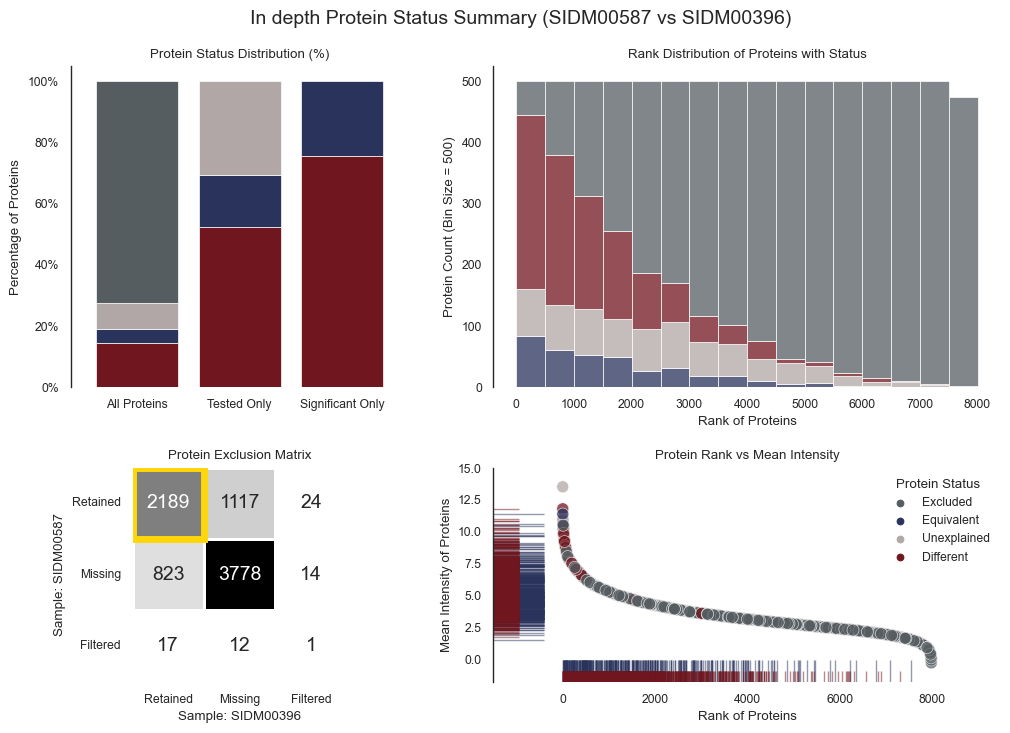

In [11]:
plots.single_pair_proteins_indepth(
    data = info_res,
    protein_data = protein_data,
    pair_names = cur_pair,
    # Data related parameters
    protein_col = "Protein",
    status_col = "Status",
    rank_col = "Rank",
    mean_col = "Mean",
    # Stats related parameters
    bin_size = 500,
    # Plot related parameters
    figsize = (12, 8),
    xMargin=1500,
    yMargin=1.5,
    save=save_to_folder,
    filepath=fig_path,
    filename = "single_pair_proteins_Indepth",
    fileformat=figure_formats,
    dont_show=False
)

#### Single Pair Testing Summary 

This figure panel consists of 4 subplots to highlight the statistical testing results of the pair.

1. First column with 2 subplots are the p-value distributions of both testing for difference and equivalence using step histogram. It also indicates the adjusted p-value with darker color in same step-histogram overlayed. The x-axis for them is the p-value from 0 to 1 and y-axis is the frequency with the bin created for step-histogram.
2. Second column is the customized volcano plot called an "Antlers Plot" that shows the log2 fold-change on x-axis and the adjusted p-value on y-axis. The y-axis represent the p-value in -log10 scale. The p-value used here is based on the protein's fold-change and if it is within the equivalence threshold or not. If it is the p-value from the equivalence test is used to plot and if it is not the p-value from the difference test is used to plot. Upper side from 0 is -log10(Adj.p-value of Df) and lower side from 0 is -log10(Adj.p-value of Eq). They both go from 0 to +Top. The Top is the maximum of the two p-values. The color of the points are based on the protein status, different, equivalent, excluded, or unexplained. Also added the dashed lines at x-axis for equivalence and difference thresholds, and at y-axis for p-value thresholds. The dashed lines are colored based on the protein status as well.
3. Last column is the count-based bar plot of the protein status. This includes the excluded protein counts as well for reference even though it is not used in the testing. The y-axis is the protein status and x-axis is the count of proteins. The color of the bars are based on the protein status.

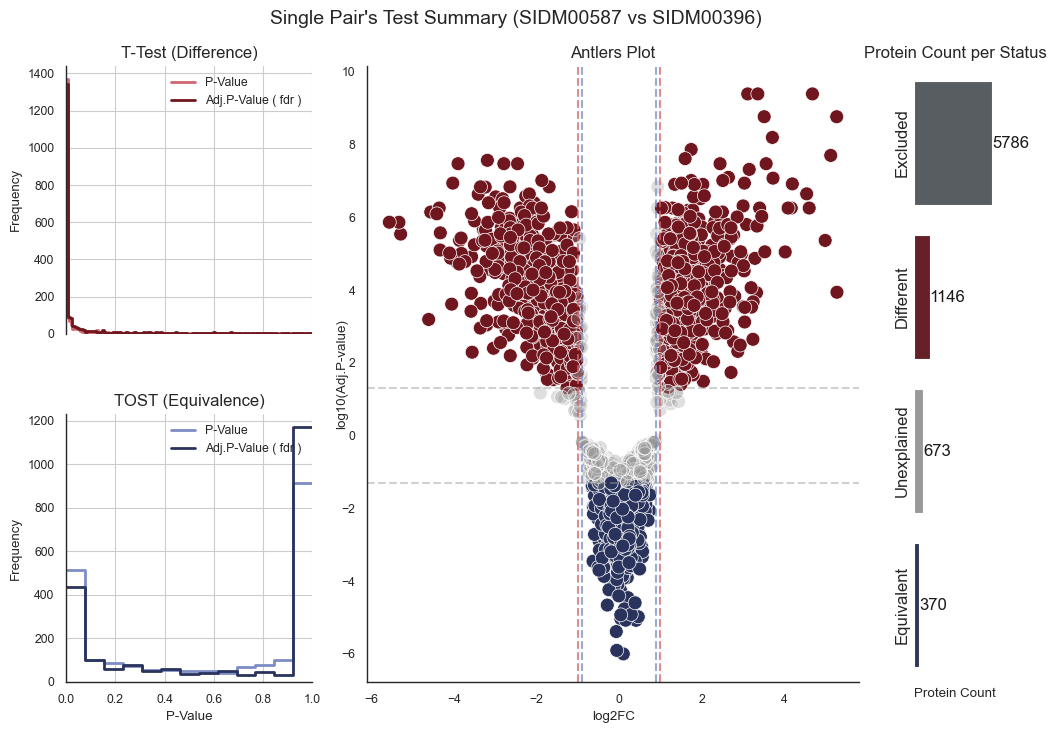

In [12]:
# Plot the results
plots.single_pair_summary(
    stat_res,
    info_res.shape[0],
    cur_pair,
    pThr=pThr,
    dfThr=dfThr,
    eqThr=eqThr,
    corr_name=correction_method,
    figsize=(12, 8),
    save=save_to_folder,
    filepath=fig_path,
    fileformat=figure_formats,
    filename="single_pair_summary",
    dont_show=False
)

## Build Summarized Results Tables

For a large set of comparisons such as this data it is important to create a couple of summary tables that can be used in many different ways when exploring questions about the data.

The summary tables that I create are as follows:

1. `groupings` - The table to hold S1 and S2 sample information for each pair
2. `combined_labels` - A simplified combined labels table to use for plotting and other purposes
3. `protein_status_matrix` - A large matrix of protein status per sample pair, to sum up protein and pair status counts (can be very large depending on the number of samples)
4. `protein_status_summary` - A summary table of protein status counts per sample pair
5. `shared_proteins` - A table to count the the status of given protein from all sample pairs

### Groupings Table

This table is a simple table that holds the metadata information copied for S1 and S2 samples for each pair. A copy of this is saved as a feather file in the `results/` folder and used in other notebooks as the main comparison metadata table. 

In [13]:
# Build grouping data
groupings = utils.create_pair_groupings(
    combs_list, 
    metadata,
    id_col="SIDM",
    pair_str=["S1", "S2"]
)
# Save the groupings to results folder
feather.write_dataframe(
    groupings, 
    f"{output_path}groupings.feather"
)
print("Groupings Shape:", groupings.shape)
# Preview the data
groupings.head()

Groupings Shape: (64620, 20)


,S1,Cell_line_S1,System_name_S1,Tissue_type_S1,Cancer_type_S1,Cancer_subtype_S1,Collection_site_S1,Status_S1,Age_S1,Sex_S1,S2,Cell_line_S2,System_name_S2,Tissue_type_S2,Cancer_type_S2,Cancer_subtype_S2,Collection_site_S2,Status_S2,Age_S2,Sex_S2
0,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female,SIDM00875,HCC1806,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
1,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female,SIDM00879,HCC1500,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female
2,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female,SIDM00629,MDA-MB-436,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Pleural_effusion,Metastatic,Adult,Female
3,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female,SIDM00122,BT-549,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Breast,Primary,Adult,Female
4,SIDM00872,HCC1954,Breast,Breast,Breast Ductal Carcinoma In Situ,Breast Ductal Carcinoma In Situ,Breast,Primary,Adult,Female,SIDM00135,Hs-578-T,Breast,Breast,Invasive Breast Carcinoma,"Breast Invasive Carcinoma, NOS",Breast,Primary,Adult,Female


### Combined Labels Table

Similar to the groupings table combined_labels holds the comparison's metadata but combines the S1 and S2 informations into a single column with a separator. This is used mostly for grouping for exploring specific questions or plotting. Additionally this adds columns with ordered labels, which means if S1 is Digestive and S2 is Hematologic, for system name the label will be `Digestive vs Hematologic`. On the other hand there could be another comparison where S1 is Hematologic and S2 is Digestive, for that system name the label will be `Digestive vs Hematologic` as well. This is to make sure that the labels are consistent and even though the order is different it can still be grouped together.

However you can keep both comparison version and ordered versions in the same table to keep a reference if the actual order is important. 

This is saved as a feather file in the `results/` folder as `labeled_pairs_groupings.feather`. In here I use ` vs ` as the separator, and keep both ordered and unordered versions. Here is the descriptive version of the table. 

In [14]:
# Combined Label for S1 and S2 Groupnigs Table
combined_labels = utils.create_pair_metadata_labels(
    groupings, 
    var_lst=["Sex", "Age", "Status", "Collection_site", "System_name", "Tissue_type", "Cancer_type", "Cancer_subtype"], 
    pair_str=["S1", "S2"],
    add_ordered_ver=True,
    add_compare_ver=True,
    new_var_lst = ["Sex", "Age", "Status", "Site", "System", "Tissue", "Cancer", "Subtype"],
    sep = " vs "
).set_index(["S1", "S2"])

# Save the combined labels to results folder
feather.write_dataframe(
    combined_labels.reset_index(), 
    f"{output_path}labeled_pairs_groupings.feather"
)
print("Combined Labels Shape:", combined_labels.shape)
combined_labels.describe()

Combined Labels Shape: (64620, 16)


,Sex_Compare,Sex,Age_Compare,Age,Status_Compare,Status,Site_Compare,Site,System_Compare,System,Tissue_Compare,Tissue,Cancer_Compare,Cancer,Subtype_Compare,Subtype
count,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620,64620
unique,4,3,4,3,4,3,892,621,66,66,325,325,906,901,5243,5243
top,Female vs Male,Female vs Male,Adult,Adult,Primary,Metastatic vs Primary,Pleural_effusion,Peripheral_blood vs Pleural_effusion,Digestive vs Hematologic,Digestive vs Hematologic,Lymphoid vs Lung,Lung vs Lymphoid,Non-Hodgkin Lymphoma vs Non-Small Cell Lung Ca...,Non-Hodgkin Lymphoma vs Non-Small Cell Lung Ca...,Breast Invasive Lobular Carcinoma vs Esophagea...,Breast Invasive Lobular Carcinoma vs Esophagea...
freq,19895,32111,46360,46360,23220,31104,1081,1739,4872,4872,2368,2368,1232,1232,36,36


### Expanded Protein Status Matrix

This is the main table that holds the protein status of each pair per protein. This can be a very large and uses a lot of memory and storage. To make the process bit more faster and efficient I used polars dataframe's here. Polars is a rust based dataframe library that is very fast and efficient. It is also very easy to use and has a pandas-like syntax. Most of the exhaustive computing done with polars than saved as feather file and can be used as pandas dataframe later on. 

To create this I go over all the `info_data` files and save them into a matrix format. The matrix is contains float values 0 for unexplained, +1 for equivalent, -1 for different, and na or None for excluded proteins per pair. This is saved as a feather file in the `results/` folder as `protein_status_matrix.feather`. And for this data it uses around 500MB of storage.

In [15]:
startTime = utils.getTime()
print(f"Constructing the protein status matrix from {len(info_file_paths)} files")
# Apply the multiprocessing to collect the status
with Pool(30) as pool:
    q = pd.DataFrame(
        dict(
            pool.map(
                utils.collect_status_for_protein_matrix,
                info_file_paths
            )
        ), 
        index=allProteins
    ).T

# Name the index
q.index.names = ["S1", "S2"]
# Reset the index
q = q.reset_index()
# Save to feather
feather.write_dataframe(
    q, 
    dest = f"{output_path}protein_status_matrix.feather"
)

# Convert the pandas to polars
q = pl.from_pandas(q)

print("Memory footprint of the matrix:", round(q.estimated_size('mb'), 3), "MB")

print(f"Time taken to construct:", utils.prettyTimer(utils.getTime()- startTime))

Constructing the protein status matrix from 64620 files
Memory footprint of the matrix: 3990.847 MB
Time taken to construct: 00h:01m:32s


Running this will take a while and uses considerable amount of memory. However the resulting table is very useful and can be used in many different ways.

After the polars data is produced, I do a quick check to see if all the indices are matching with groupings S1 and S2 orders. This is to make sure that the data is consistent and no errors are present. If an error happens it will be caught here and the user can go back and fix the error.

In [16]:
# Create assert statements to test S1 and S2
s1_test = set(q["S1"]) - set(groupings["S1"])
s2_test = set(q["S2"]) - set(groupings["S2"])
if len(s1_test) > 0:
    print(f"Unique S1 is not matched in groupings, Missing elements: {s1_test}")
else:
    print("All S1 elements are matched in groupings")
if len(s2_test) > 0:
    print(f"Unique S2 is not matched in groupings, Missing elements: {s2_test}")
else:
    print("All S2 elements are matched in groupings")

All S1 elements are matched in groupings
All S2 elements are matched in groupings


### Protein Status Summary Table

This table holds the pair's protein status counts and percentages, to give an idea how much of the proteins are different, equivalent, excluded, or unexplained for given pair. This is saved as a feather file in the `results/` folder as `protein_status_summary.feather`. This is a very useful table to get an idea of the overall status of the pairs. Here is the description of the columns of this table.

- S1 and S2 columns holds the sample names representing the pair in the row (S1 vs S2)
- `Ms` - Number of excluded proteins
- `Ux` - Number of unexplained proteins
- `Df` - Number of different proteins
- `Eq` - Number of equivalent proteins
- `tested`- Number of tested proteins (Df + Eq + Ux)
- `%Ux` - Percentage of unexplained proteins
- `%Df` - Percentage of different proteins
- `%Eq` - Percentage of equivalent proteins

The percentage calculation for Df and Eq can be done with excluded & unexplained, only unexplained, or only significant proteins, depending on the user's preference. The default is to use all tested proteins.

In [17]:
# Creating a protein status percentages for each pair
combs = q.select(
    "S1", "S2"
)

prtOnly = q.select(
    pl.exclude("S1", "S2")
)

ux_cnts = (prtOnly==0.0).sum(axis=1)
df_cnts = (prtOnly==-1.0).sum(axis=1)
eq_cnts = (prtOnly==1.0).sum(axis=1)
ts_cnts = (ux_cnts + df_cnts + eq_cnts)
# if x is null, then it is missing
ms_cnts = len(prtOnly.columns) - ts_cnts

prt_status = pl.DataFrame(
    {
        "S1":combs["S1"],
        "S2":combs["S2"],
        "Ms":ms_cnts,
        "Ux":ux_cnts,
        "Df":df_cnts,
        "Eq":eq_cnts,
        "tested": ts_cnts,
        "%Ux": ux_cnts/ts_cnts * 100,
        "%Df": df_cnts/ts_cnts * 100,
        "%Eq": eq_cnts/ts_cnts * 100,
    }
).fill_nan(0)

# Save as feather
feather.write_dataframe(
    (prt_status).to_arrow(),                  # Convert to arrow table format
    dest = f"{output_path}protein_status_summary.feather"   # Save to feather
)

prt_status.sort(["Eq", "%Eq"])

S1,S2,Ms,Ux,Df,Eq,tested,%Ux,%Df,%Eq
str,str,u32,u32,u32,u32,u32,f64,f64,f64
"""SIDM00687""","""SIDM00388""",5987,931,868,189,1988,46.830986,43.661972,9.507042
"""SIDM00687""","""SIDM00142""",5627,695,1447,206,2348,29.599659,61.626917,8.773424
"""SIDM00388""","""SIDM00486""",6130,665,973,207,1845,36.04336,52.737127,11.219512
"""SIDM00218""","""SIDM00460""",5787,931,1045,212,2188,42.550274,47.760512,9.689214
"""SIDM00442""","""SIDM00388""",6157,625,981,212,1818,34.378438,53.960396,11.661166
"""SIDM00687""","""SIDM00888""",5701,999,1061,214,2274,43.931398,46.657872,9.41073
"""SIDM00388""","""SIDM00929""",6116,731,913,215,1859,39.322216,49.112426,11.565358
"""SIDM00388""","""SIDM00794""",6187,678,894,216,1788,37.919463,50.0,12.080537
"""SIDM00687""","""SIDM01119""",5995,630,1131,219,1980,31.818182,57.121212,11.060606


### Summary of Shared Proteins on All Pairs

This table holds the counts and percentages of pairs's status a given protein is found in. This is saved as a feather file in the `results/` folder as `shared_proteins_all_pairs.feather`.  Here is the description of the columns of this table.

- `Protein` - The protein accession id
- `Mean` - The mean log2 intensity of the protein across all samples
- `Rank` - The rank of the protein based on the descending order of the mean intensity
- `CV` - The coefficient of variation of the protein across all samples
- `Df` - Number of pairs where the protein is different
- `Eq` - Number of pairs where the protein is equivalent
- `tested` - Number of pairs where the protein is tested (Df + Eq + Ux)
- `%Df` - Percentage of pairs where the protein is different (Df / tested)
- `%Eq` - Percentage of pairs where the protein is equivalent (Eq / tested)
- `%tested` - Percentage of pairs where the protein is tested (tested / total pairs)
- `(Eq - Df)` - The difference between the number of pairs where the protein is equivalent and different
- `(%Eq - %Df)` - The difference between the percentage of pairs where the protein is equivalent and different (Relative Stability Metric (RSM))

The last column RSM and %tested are two important information to call a protein quantitatively stable or variable based in this type of large scale comparisons. And we use them extensively in the next notebooks to establish protein sets.

In [18]:
# Calculate the values
ux_cnts = (prtOnly==0.0).sum(axis=0)*1.
df_cnts = (prtOnly==-1.0).sum(axis=0)*1.
eq_cnts = (prtOnly==1.0).sum(axis=0)*1.
ts_cnts = (ux_cnts + df_cnts + eq_cnts)

# Create the shared in all proteins table
shared_in_all_prots = pl.concat(
    [
        df_cnts,
        eq_cnts,
        ts_cnts,
        df_cnts/ts_cnts * 100,
        eq_cnts/ts_cnts * 100,
        ts_cnts/prtOnly.shape[0] * 100
    ]
).transpose().fill_nan(0)
shared_in_all_prots.columns = [
    "Df", "Eq", "tested", 
    "%Df", "%Eq", "%tested",

]
# Add the protein information to the table
shared_in_all_prots.insert_at_idx(
    0, 
    pl.Series("Protein", prtOnly.columns)
)
shared_in_all_prots.insert_at_idx(
    1,
    pl.Series("Mean", np.log2(cell_averaged.mean(axis=1)).tolist())
)
shared_in_all_prots.insert_at_idx(
    2,
    pl.Series("Rank", cell_averaged.mean(axis=1).rank(ascending=False).tolist())
)
shared_in_all_prots.insert_at_idx(
    3,
    pl.Series("CV", (( cell_averaged.std(axis=1) / cell_averaged.mean(axis=1) ) * 100).tolist())
)

# Create additional columns
shared_in_all_prots = shared_in_all_prots.with_columns(
    (pl.col("Eq") - pl.col("Df")).alias("(Eq-Df)"),
    (pl.col("%Eq") - pl.col("%Df")).alias("%(EQ-DF)")
).fill_nan(0)

# Save as feather
feather.write_dataframe(
    (shared_in_all_prots).to_arrow(),                  # Convert to arrow table format
    dest = f"{output_path}shared_proteins_all_pairs.feather"   # Save to feather
)

shared_in_all_prots.sort(["tested", "Eq", "Df"])

Protein,Mean,Rank,CV,Df,Eq,tested,%Df,%Eq,%tested,(Eq-Df),%(EQ-DF)
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""Q9BTK6""",1.227127,7840.0,51.977917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q14050""",1.660303,7559.0,32.833286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q9NZG7""",3.610453,3537.0,45.329055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q69YW2""",1.783887,7429.0,77.954669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""O43248""",3.261235,4312.0,103.746016,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""P04798""",1.889862,7308.0,40.135232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""P80511""",2.371866,6474.0,44.818951,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q9HCE7""",2.845126,5299.0,54.728886,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""Q9UPQ9""",1.397095,7757.0,52.962115,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Quick Glance at the Results

Before finishing the notebook I will take a quick glance at overall results to see if there are any issue or interesting observations.

## Protein Status Distributions

This first plot plots each protein status from all pairs as overlayed histograms, highlighting the percentage of status observed in all pairs. This is a quick way to see if there are any issues with the data or the testing.

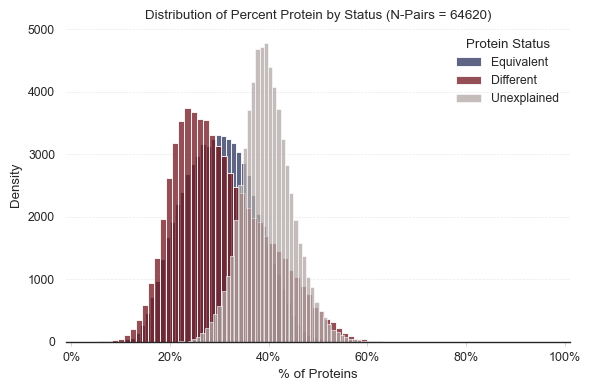

In [19]:
# Plot the distributions of the percent equivalent, different, and unexplained proteins in pairs
plot_data = prt_status.to_pandas()
# Plot the distributions of percent status
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 4),
    # sharex=True
    # sharey=True
)
sns.histplot(
    (plot_data["%Eq"]),  
    label="Equivalent", 
    color=status_colors["Equivalent"], 
    bins=50
)
sns.histplot(
    (plot_data["%Df"]),  
    label="Different", 
    color=status_colors["Different"], 
    bins=50
)
sns.histplot(
    (plot_data["%Ux"]),  
    label="Unexplained", 
    color=status_colors["Unexplained"], 
    bins=50
)

ax.legend(
    # loc="upper left",
    # bbox_to_anchor=(1, 1),
    frameon=False,
    ncol=1,
    # fontsize=12,
    title="Protein Status"
)

# X limits
ax.set_xlim(-1, 101)

# Made the x-axis a percentage
ax.xaxis.set_major_formatter(
    mtick.PercentFormatter()
)

# set grids on y
ax.grid(
    axis="y",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.5
)

# add ticks lines to x
ax.tick_params(
    axis='x',
    bottom=True,
    color="lightgray",
    width=0.75,
    length=3,
    direction='out',
    labelsize=9,
    pad=4
)


ax.set_xlabel("% of Proteins")
ax.set_ylabel("Density")
ax.set_title(
    "Distribution of Percent Protein by Status (N-Pairs = " + 
    str(plot_data.shape[0]) +
    ")"
)

sns.despine(
    left=True,
    bottom=False
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Cumulative_Protein_Status_Percents_Histplot",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

On average 40 to 45% of the proteins in pairs seemed to be unexplained, which is a bit high, but there are multiple reasons for it. 

1. When a protein's log2 fold-change for a given pair, is between 1 and 0.9 it is automatically considered unexplained since it is not within the equivalence threshold.
2. The precision or quality of the data is not very high. 
3. Could reduce the CV threshold to 50 or lower to only considered very reliably quantified proteins, but that would also increase the number of excluded proteins.
4. The number of replicates are not enough to get a good estimate of the variance and with the fdr correction it is hard to get a good estimate of the p-value.

## Tested Protein Distribution

This plot shows the distribution of the number of tested proteins per pair. 

Number of proteins tested more than 95% of pairs: 1230
Number of proteins tested less than 5% of pairs: 3419


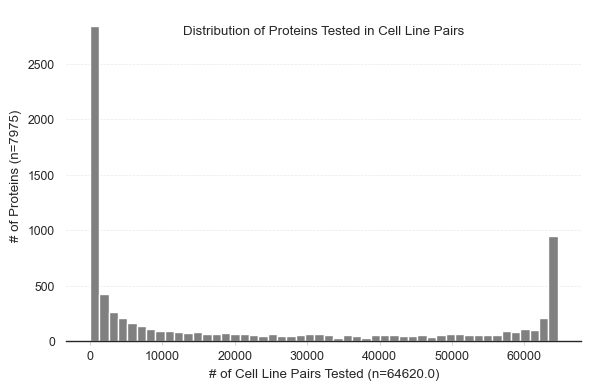

In [20]:
plot_data = shared_in_all_prots.to_pandas()
# Plotting the Distribution of Proteins Tested in Pairs
fig, ax = plt.subplots(
    nrows=1,
    ncols=1,
    figsize=(6, 4),
    # sharex=True
    # sharey=True
)

# Plot the data
sns.histplot(
    plot_data["tested"],
    ax=ax,
    bins=50,
    color='gray', 
    # edgecolor=def_colors[4],
    linewidth=1,
    alpha=1
)

# Set the x and y labels
ax.set_xlabel(
    (
        "# of Cell Line Pairs Tested (n=" + 
        str(plot_data["tested"].max()) +
        ")"
    )
)
ax.set_ylabel(
    (
        "# of Proteins (n=" + 
        str(plot_data.shape[0]) + 
        ")"
    ), 
)
ax.set_title(
    "Distribution of Proteins Tested in Cell Line Pairs", 
    y=0.90,
)

# set grids on y
ax.grid(
    axis="y",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.5
)

# add ticks lines to x
ax.tick_params(
    axis='x',
    bottom=True,
    color="lightgray",
    width=0.75,
    length=3,
    direction='out',
    labelsize=9,
    pad=4
)

sns.despine(
    left=True,
    bottom=False,
)
plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "Distribution_of_Proteins_Tested_in_AllPairs",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )


print(
    "Number of proteins tested more than 95% of pairs:", 
    (plot_data["%tested"] > 95).sum()
)

print(
    "Number of proteins tested less than 5% of pairs:", 
    (plot_data["%tested"] < 5).sum()
)

There are more than 1000 proteins tested in majority of the pairs (around 95% of 64620), where on the other hand there are more than 3000 proteins tested less than 5% of the pairs. This is an unfortunate artifact from the dataset, where due to the large scale nature of the data the depth is not very high.

### RSM vs Tested % Scatter Plot

This is a proof of concept plot to show the relationship between the RSM and the tested percentage. Using size of bubble to indicate the percentage of pairs tested and color to indicate the RSM (Eq% - Df%).

Proteins with exclusive tendency to be quantitatively variable are darker red, where proteins with exclusive tendency to be quantitatively stable are darker blue. The size of the bubble indicates the percentage of pairs tested. The larger the bubble the more pairs the protein is tested in.

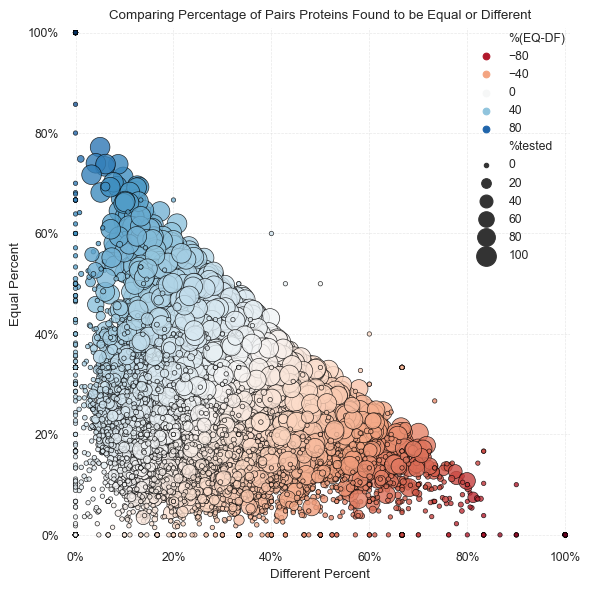

In [21]:
# Initialize the figure
fig, ax = plt.subplots(
    nrows=1, 
    ncols=1,
    figsize=(6, 6)
    # sharex=True,
    # sharey=True
)

sns.scatterplot(
    data=plot_data,
    x="%Df",
    y="%Eq",
    hue="%(EQ-DF)",
    size="%tested", 
    sizes=(10, 200),
    palette="RdBu",
    # Style 
    edgecolor="black",
    linewidth=0.5,
    alpha=0.8,
    # Legend
    legend="brief",
    ax=ax, 
    rasterized=True
)

ax.set_xlabel("Different Percent")
ax.set_ylabel("Equal Percent")
ax.set_title("Comparing Percentage of Pairs Proteins Found to be Equal or Different")
ax.legend(
    borderaxespad=0.0,
    frameon=False
)

# Set x and y limits
ax.set_xlim(-1, 101)
ax.set_ylim(-1, 101)

# Replace x and y ticks with % symbols
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

# set grids on x and y
ax.grid(
    axis="both",
    color="lightgray",
    linestyle='--',
    linewidth=0.5,
    alpha=0.5
)

sns.despine(
    left=True,
    bottom=True,
)

plt.tight_layout()

# Save the figure, if save_to_folder is True
if save_to_folder:
    plots.save_figures(
        fig_obj = plt.gcf(),
        filename = "ProteinStatusPercent_RelativeStability_ScatterWithSize",
        filepath = fig_path,
        fileformat = figure_formats,
        dpi = figure_dpi,
        transparent = transparet_bg
    )

# Save Additional Data

## Save the Protein Information and Rank Data

I will merge the averaged replicates data with protein information and protein mean, rank, cv information to create a single reference table that can be used in the next notebooks. This is saved as a feather file in the `data/results/` folder as `protein_expanded_data.feather`.

In [22]:
combined_data = protein_info_data.set_index("entry").join(
    protein_data
).join(
    cell_averaged
)

feather.write_dataframe(
    combined_data.reset_index(), 
    f"{output_path}protein_expanded_data.feather"
)

print("Combined Data Shape:", combined_data.shape)
combined_data.head().iloc[:, :7]

Combined Data Shape: (7975, 366)


,entryName,proteinDescription,geneName,Mean,Rank,CV,SIDM00018
entry,,,,,,,
Q9Y651,SOX21_HUMAN,Transcription factor SOX-21,SOX21,2.6725,5215.0000,34.3192,NaN
P37108,SRP14_HUMAN,ignal recognition particle 14 kDa protein,SRP14,6.5487,423.0000,39.5648,137.3901
Q96JP5,ZFP91_HUMAN,E3 ubiquitin-protein ligase ZFP91,ZFP91,3.5780,3040.0000,30.8813,12.4335
Q9Y4H2,IRS2_HUMAN,Insulin receptor substrate 2,IRS2,2.3271,6163.0000,66.4872,NaN
P36578,RL4_HUMAN,Large ribosomal subunit protein uL4,RPL4,7.5242,197.0000,30.6928,242.9197


The first 6 columns are the protein information, mean, rank, and cv of all samples, and rest are samples as replicates averaged on each protein. This is essentially same as three individual tables from `data/processed/` folder merged into one table and saved as feather file to `data/results/` folder to be used in the next notebooks.

## Supplementary Data 

This part is used to create necessary supplementary tables in one folder for given analysis so I can assemble them into a single Excel file later on. I could have done this in the pandas' excel writer in one go but I prefer to do it in seperate steps to ensure that the data is written correctly as well as to keep the time spent on writing the file to a minimum. Writing to xlsx is notoriously slow compared to csv, and I want to avoid that as much as possible.

Each table that might go to a supplementary file is saved as a seperate csv file in the `data/supplementary/` folder. In this notebook I am saving the following tables:

- **Table S2.1**: This table contains the cell line information of the samples used in the testing. It is saved as `table_s2_1.csv`.
- **Table S2.2**: This table contains the averaged replicates of the protein intensities used in the testing. It is saved as `table_s2_2.csv`.
- **Table S2.3**: This table contains the summarized testing result per cell line pair, contining number and percentages of equivalent, different, excluded, and unexplained proteins. It is saved as `table_s2_3.csv`.
- **Table S2.4**: This table contains the summarized testing result per protein, containing number and percentages of pairs a given protein is equivalent, different, and unexplained. This includes %tested and RSM values used to select proteins for next notebooks. It is saved as `table_s2_4.csv`.

In [23]:
# Save the cell line information to table_s2_1.csv
metadata.to_csv(
    f"{supp_path}table_s2_1.csv", 
    index=False
)

# Save the average protein data to table_s2_2.csv
combined_data.to_csv(
    f"{supp_path}table_s2_2.csv", 
    index=False
)

# Save the pair specific protein status to table_s2_3.csv
groupings.set_index(["S1", "S2"])[["Cell_line_S1", "Cell_line_S2"]].join(
    prt_status.to_pandas().set_index(["S1", "S2"])
).to_csv(
    f"{supp_path}table_s2_3.csv"
)

# Save the protein status matrix to table_s2_4.csv
protein_info_data.set_index("entry").join(
    shared_in_all_prots.to_pandas().set_index("Protein")
).to_csv(
    f"{supp_path}table_s2_4.csv"
)



# Conclusion

In this notebook I've applied the `questvar` testing framework to the 360 cancer cell lines samples and created summary tables to be used in 3 notebooks. I've also checked the overall testing results with some high-level sanity-check plots. 

The **"RSM"** or Relative Stability Metric is a very important metric to check the quantitative stability from all tested pairs or group of tested pairs depending on the question. Also %tested where it shows if a protein is tested enough times to be even considered for quantitaive stability of variability.

In [24]:
print("Notebook Execution Time:", utils.prettyTimer(utils.getTime() - nbStartTime))

Notebook Execution Time: 00h:03m:43s
